In [1]:
!pip install smdebug --upgrade
!pip install s3fs --upgrade
!pip install nbconvert

  Using cached fsspec-2024.6.1-py3-none-any.whl.metadata (11 kB)
Using cached fsspec-2024.6.1-py3-none-any.whl (177 kB)
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2023.6.0
ERROR: Cannot uninstall fsspec 2023.6.0, RECORD file not found. You might be able to recover from this via: 'pip install --force-reinstall --no-deps fsspec==2023.6.0'.


In [2]:
%pip install shap

Note: you may need to restart the kernel to use updated packages.


In [3]:
import re
import s3fs
import shap
import time
import boto3
import pandas as pd
import numpy as np

from itertools import islice
import matplotlib.pyplot as plt

import sagemaker
from sagemaker.xgboost.estimator import XGBoost
from sagemaker.session import Session
from sagemaker.inputs import TrainingInput
from sagemaker.debugger import DebuggerHookConfig,CollectionConfig
from sagemaker.debugger import rule_configs, Rule
from smdebug.trials import create_trial
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner
)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
[2024-08-30 20:02:24.724 default:16565 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None


In [4]:
# S3 Bucket name
bucket = 'sagemaker-us-east-1-863828306212'

In [5]:
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
region = sagemaker_session.boto_region_name

In [6]:
# Preprocess the dataset
def preprocess_data(file_path):
    df = pd.read_csv(file_path)
    # Convert to datetime columns
    df["firstorder"]=pd.to_datetime(df["firstorder"],errors='coerce')
    df["lastorder"] = pd.to_datetime(df["lastorder"],errors='coerce')
    # Drop Rows with null values
    df = df.dropna()    
    # Create Column which gives the days between the last order and the first order
    df["first_last_days_diff"] = (df['lastorder']-df['firstorder']).dt.days
    # Create Column which gives the days between when the customer record was created and the first order
    df['created'] = pd.to_datetime(df['created'])
    df['created_first_days_diff']=(df['created']-df['firstorder']).dt.days
    # Drop Columns
    df.drop(['custid','created','firstorder','lastorder'],axis=1,inplace=True)
    # Apply one hot encoding on favday and city columns
    df = pd.get_dummies(df,prefix=['favday','city'],columns=['favday','city'])
    categorical_cols = ['favday_Friday', 'favday_Monday', 'favday_Saturday', 'favday_Sunday',
                        'favday_Thursday', 'favday_Tuesday', 'favday_Wednesday', 'city_BLR',
                        'city_BOM', 'city_DEL', 'city_MAA']
    df[categorical_cols] = df[categorical_cols].replace({True: 1, False: 0})
    return df

In [7]:
# Set the required configurations
model_name = "churn_model"
env = "dev"
# Preprocess the dataset
storedata = preprocess_data(f"s3://{bucket}/data/storedata_total.csv")

/tmp/ipykernel_16565/3783056170.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["firstorder"]=pd.to_datetime(df["firstorder"],errors='coerce')
/tmp/ipykernel_16565/3783056170.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["lastorder"] = pd.to_datetime(df["lastorder"],errors='coerce')
/tmp/ipykernel_16565/3783056170.py:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['created'] = pd.to_datetime(df['created'])


In [8]:
storedata.head()

,retained,esent,eopenrate,eclickrate,avgorder,ordfreq,paperless,refill,doorstep,first_last_days_diff,...,favday_Monday,favday_Saturday,favday_Sunday,favday_Thursday,favday_Tuesday,favday_Wednesday,city_BLR,city_BOM,city_DEL,city_MAA
0,0,29,100.000000,3.448276,14.52,0.000000,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
1,1,95,92.631579,10.526316,83.69,0.181641,1,1,1,1024,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0.000000,0.000000,33.58,0.059908,0,0,0,217,...,0,0,0,0,0,1,0,0,1,0
3,0,0,0.000000,0.000000,54.96,0.000000,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
4,1,30,90.000000,13.333333,111.91,0.008850,0,0,0,791,...,1,0,0,0,0,0,0,1,0,0


In [9]:
def split_datasets(df):
    y=df.pop("retained")
    X_pre = df
    y_pre = y.to_numpy().reshape(len(y),1)
    feature_names = list(X_pre.columns)
    X= np.concatenate((y_pre,X_pre),axis=1)
    np.random.shuffle(X)
    train,validation,test=np.split(X,[int(.7*len(X)),int(.85*len(X))])
    return feature_names,train,validation,test

In [10]:
# Split dataset
feature_names,train,validation,test = split_datasets(storedata)

In [11]:
# Save datasets in Amazon S3
pd.DataFrame(train).to_csv(f"s3://{bucket}/data/train/train.csv",header=False,index=False)
pd.DataFrame(validation).to_csv(f"s3://{bucket}/data/validation/validation.csv",header=False,index=False)
pd.DataFrame(test).to_csv(f"s3://{bucket}/data/test/test.csv",header=False,index=False)

In [12]:
# Training and Validation Input for SageMaker Training job
s3_input_train = TrainingInput(
    s3_data=f"s3://{bucket}/data/train/",content_type="csv")
s3_input_validation = TrainingInput(
    s3_data=f"s3://{bucket}/data/validation/",content_type="csv")

In [13]:
# Hyperparameter used
fixed_hyperparameters = {
    "eval_metric":"auc",
    "objective":"binary:logistic",
    "num_round":"100",
    "rate_drop":"0.3",
    "tweedie_variance_power":"1.4"
}

In [14]:
# Use the built-in SageMaker algorithm
sess = sagemaker.Session()
container = sagemaker.image_uris.retrieve("xgboost",region,"0.90-2")

estimator = sagemaker.estimator.Estimator(
    container,
    role,
    instance_count=1,
    hyperparameters=fixed_hyperparameters,
    instance_type="ml.m5.xlarge",
    output_path="s3://{}/output".format(bucket),
    sagemaker_session=sagemaker_session
)

In [15]:
hyperparameter_ranges = {
    "eta": ContinuousParameter(0, 1),
    "min_child_weight": ContinuousParameter(1, 10),
    "alpha": ContinuousParameter(0, 2),
    "max_depth": IntegerParameter(1, 10),
}

In [16]:
objective_metric_name = "validation:auc"

In [17]:
tuner = HyperparameterTuner(
estimator, objective_metric_name,
hyperparameter_ranges,max_jobs=10,max_parallel_jobs=2)

In [18]:
# Tune
tuner.fit({
    "train":s3_input_train,
    "validation":s3_input_validation
    },include_cls_metadata=False)

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


.................................................................!


In [19]:
# Explore the best model generated
tuning_job_result = boto3.client("sagemaker").describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuner.latest_tuning_job.job_name
)

In [20]:
job_count = tuning_job_result["TrainingJobStatusCounters"]["Completed"]
print("%d training jobs have completed" %job_count)
# 10 training jobs have completed

10 training jobs have completed


In [21]:
# Get the best training job

from pprint import pprint
if tuning_job_result.get("BestTrainingJob",None):
    print("Best Model found so far:")
    pprint(tuning_job_result["BestTrainingJob"])
else:
    print("No training jobs have reported results yet.")

Best Model found so far:
{'CreationTime': datetime.datetime(2024, 8, 30, 20, 2, 34, tzinfo=tzlocal()),
 'FinalHyperParameterTuningJobObjectiveMetric': {'MetricName': 'validation:auc',
                                                 'Value': 0.9804220199584961},
 'ObjectiveStatus': 'Succeeded',
 'TrainingEndTime': datetime.datetime(2024, 8, 30, 20, 4, 36, tzinfo=tzlocal()),
 'TrainingJobArn': 'arn:aws:sagemaker:us-east-1:863828306212:training-job/sagemaker-xgboost-240830-2002-001-6b6b78f9',
 'TrainingJobName': 'sagemaker-xgboost-240830-2002-001-6b6b78f9',
 'TrainingJobStatus': 'Completed',
 'TrainingStartTime': datetime.datetime(2024, 8, 30, 20, 3, 17, tzinfo=tzlocal()),
 'TunedHyperParameters': {'alpha': '1.042589922480077',
                          'eta': '0.1809423603991417',
                          'max_depth': '10',
                          'min_child_weight': '4.192610900928211'}}


In [22]:
best_hyperparameters = tuning_job_result["BestTrainingJob"]["TunedHyperParameters"]

In [23]:
best_hyperparameters

{'alpha': '1.042589922480077',
 'eta': '0.1809423603991417',
 'max_depth': '10',
 'min_child_weight': '4.192610900928211'}

## XGBoost Model with SageMaker Debugger

In [24]:
hyperparameters = {**fixed_hyperparameters,**best_hyperparameters}
save_interval = 5
base_job_name = "demo-smdebug-xgboost-churn-classification"

In [25]:
container = sagemaker.image_uris.retrieve("xgboost",region,"0.90-2")

In [26]:
estimator = sagemaker.estimator.Estimator(
    container,
    role,
    base_job_name=base_job_name,
    instance_count=1,
    instance_type="ml.t3.xlarge",
    output_path="s3://{}/output".format(bucket),
    sagemaker_session=sess,
    hyperparameters=hyperparameters,
    max_run=1800,
    debugger_hook_config=DebuggerHookConfig(
        s3_output_path=f"s3://{bucket}/debugger/",  # Required
        collection_configs=[
            CollectionConfig(
                name="metrics",
                parameters={
                    "save_interval": "5"
                }),
            CollectionConfig(
                name="feature_importance", parameters={"save_interval": "5"}
            ),
            CollectionConfig(name="full_shap", parameters={"save_interval": "5"}),
            CollectionConfig(name="average_shap", parameters={"save_interval": "5"}),
        ]
    ),
    rules=[
        Rule.sagemaker(
            rule_configs.loss_not_decreasing(),
            rule_parameters={
                "collection_names": "metrics",
                "num_steps": "10",
            },
        ),
    ]
)

In [27]:
estimator.fit(
        {"train":s3_input_train,"validation":s3_input_validation},wait=False
    )

INFO:sagemaker:Creating training-job with name: demo-smdebug-xgboost-churn-classificati-2024-08-30-20-08-07-604


In [28]:
for _ in range(36):
    job_name = estimator.latest_training_job.name
    client = estimator.sagemaker_session.sagemaker_client
    description = client.describe_training_job(TrainingJobName=job_name)
    training_job_status = description["TrainingJobStatus"]
    rule_job_summary = estimator.latest_training_job.rule_job_summary()
    rule_evaluation_status = rule_job_summary[0]["RuleEvaluationStatus"]
    print(
        "Training job status: {}, Rule Evaluation Status: {}".format(
            training_job_status, rule_evaluation_status
        )
    )
    if training_job_status in ["Completed", "Failed"]:
        break
    time.sleep(10)

Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation

## Analyze Debugger Output

In [29]:
estimator.latest_training_job.rule_job_summary()

[{'RuleConfigurationName': 'LossNotDecreasing',
  'RuleEvaluationJobArn': 'arn:aws:sagemaker:us-east-1:863828306212:processing-job/demo-smdebug-xgboost-churn-LossNotDecreasing-5195f5a8',
  'RuleEvaluationStatus': 'InProgress',
  'LastModifiedTime': datetime.datetime(2024, 8, 30, 20, 12, 52, 823000, tzinfo=tzlocal())}]

In [30]:
s3_output_path = estimator.latest_job_debugger_artifacts_path()
trial = create_trial(s3_output_path)

[2024-08-30 20:13:11.012 default:16565 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-863828306212/debugger/demo-smdebug-xgboost-churn-classificati-2024-08-30-20-08-07-604/debug-output


In [31]:
trial.tensor_names()

[2024-08-30 20:13:12.480 default:16565 INFO trial.py:197] Training has ended, will refresh one final time in 1 sec.
[2024-08-30 20:13:13.503 default:16565 INFO trial.py:210] Loaded all steps


['average_shap/f0',
 'average_shap/f1',
 'average_shap/f10',
 'average_shap/f11',
 'average_shap/f12',
 'average_shap/f13',
 'average_shap/f14',
 'average_shap/f15',
 'average_shap/f16',
 'average_shap/f17',
 'average_shap/f18',
 'average_shap/f19',
 'average_shap/f2',
 'average_shap/f20',
 'average_shap/f3',
 'average_shap/f4',
 'average_shap/f5',
 'average_shap/f6',
 'average_shap/f7',
 'average_shap/f8',
 'average_shap/f9',
 'feature_importance/cover/f0',
 'feature_importance/cover/f1',
 'feature_importance/cover/f10',
 'feature_importance/cover/f11',
 'feature_importance/cover/f12',
 'feature_importance/cover/f13',
 'feature_importance/cover/f14',
 'feature_importance/cover/f15',
 'feature_importance/cover/f16',
 'feature_importance/cover/f17',
 'feature_importance/cover/f18',
 'feature_importance/cover/f19',
 'feature_importance/cover/f2',
 'feature_importance/cover/f20',
 'feature_importance/cover/f3',
 'feature_importance/cover/f4',
 'feature_importance/cover/f5',
 'feature_impo

In [32]:
trial.tensor("average_shap/f1").values()

{0: array([0.00145401], dtype=float32),
 5: array([0.00983115], dtype=float32),
 10: array([0.02404628], dtype=float32),
 15: array([0.04323517], dtype=float32),
 20: array([0.06967835], dtype=float32),
 25: array([0.09778746], dtype=float32),
 30: array([0.11591551], dtype=float32),
 35: array([0.13037686], dtype=float32),
 40: array([0.1509676], dtype=float32),
 45: array([0.16143025], dtype=float32),
 50: array([0.16637982], dtype=float32),
 55: array([0.16524945], dtype=float32),
 60: array([0.17386657], dtype=float32),
 65: array([0.17044143], dtype=float32),
 70: array([0.18116033], dtype=float32),
 75: array([0.18615597], dtype=float32),
 80: array([0.1905569], dtype=float32),
 85: array([0.19129106], dtype=float32),
 90: array([0.19889589], dtype=float32),
 95: array([0.20019819], dtype=float32)}

In [33]:
MAX_PLOTS = 35


def get_data(trial, tname):
    """
    For the given tensor name, walks though all the iterations
    for which you have data and fetches the values.
    Returns the set of steps and the values.
    """
    tensor = trial.tensor(tname)
    steps = tensor.steps()
    vals = [tensor.value(s) for s in steps]
    return steps, vals


def match_tensor_name_with_feature_name(tensor_name, feature_names=feature_names):
    feature_tag = tensor_name.split("/")
    for ifeat, feature_name in enumerate(feature_names):
        if feature_tag[-1] == "f{}".format(str(ifeat)):
            return feature_name
    return tensor_name


def plot_collection(trial, collection_name, regex=".*", figsize=(8, 6)):
    """
    Takes a `trial` and a collection name, and
    plots all tensors that match the given regex.
    """
    fig, ax = plt.subplots(figsize=figsize)
    tensors = trial.collection(collection_name).tensor_names
    matched_tensors = [t for t in tensors if re.match(regex, t)]
    for tensor_name in islice(matched_tensors, MAX_PLOTS):
        steps, data = get_data(trial, tensor_name)
        ax.plot(steps, data, label=match_tensor_name_with_feature_name(tensor_name))

    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    ax.set_xlabel("Iteration")

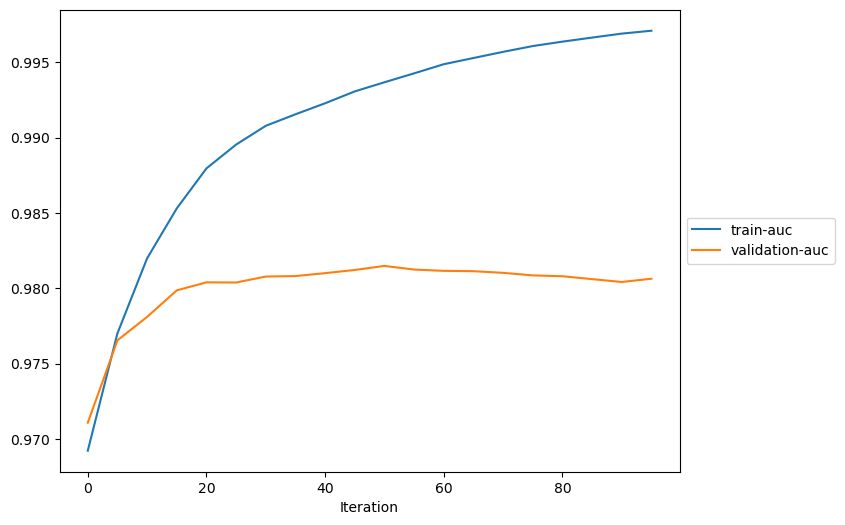

In [34]:
plot_collection(trial, "metrics")

In [35]:
def plot_feature_importance(trial, importance_type="weight"):
    SUPPORTED_IMPORTANCE_TYPES = ["weight", "gain", "cover", "total_gain", "total_cover"]
    if importance_type not in SUPPORTED_IMPORTANCE_TYPES:
        raise ValueError(f"{importance_type} is not one of the supported importance types.")
    plot_collection(trial, "feature_importance", regex=f"feature_importance/{importance_type}/.*")

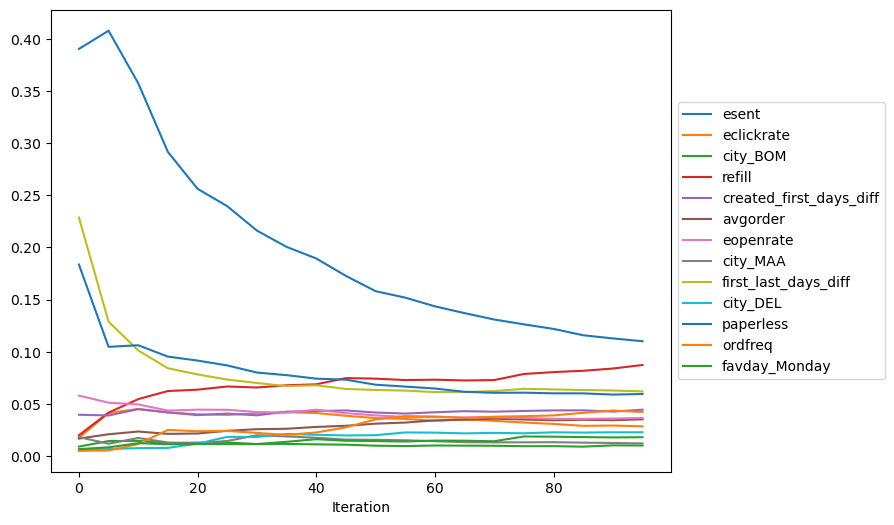

In [36]:
plot_feature_importance(trial, importance_type="cover")

## SHAP

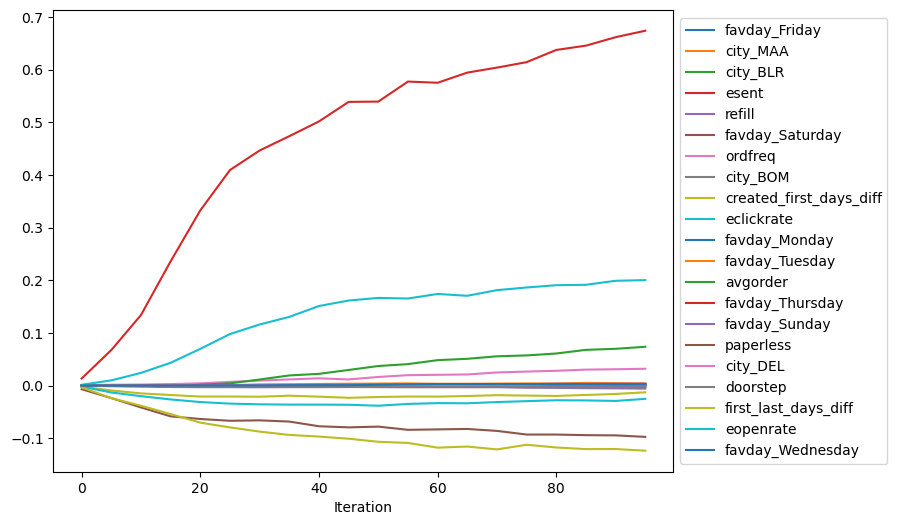

In [37]:
plot_collection(trial, "average_shap")

## Global Explanations

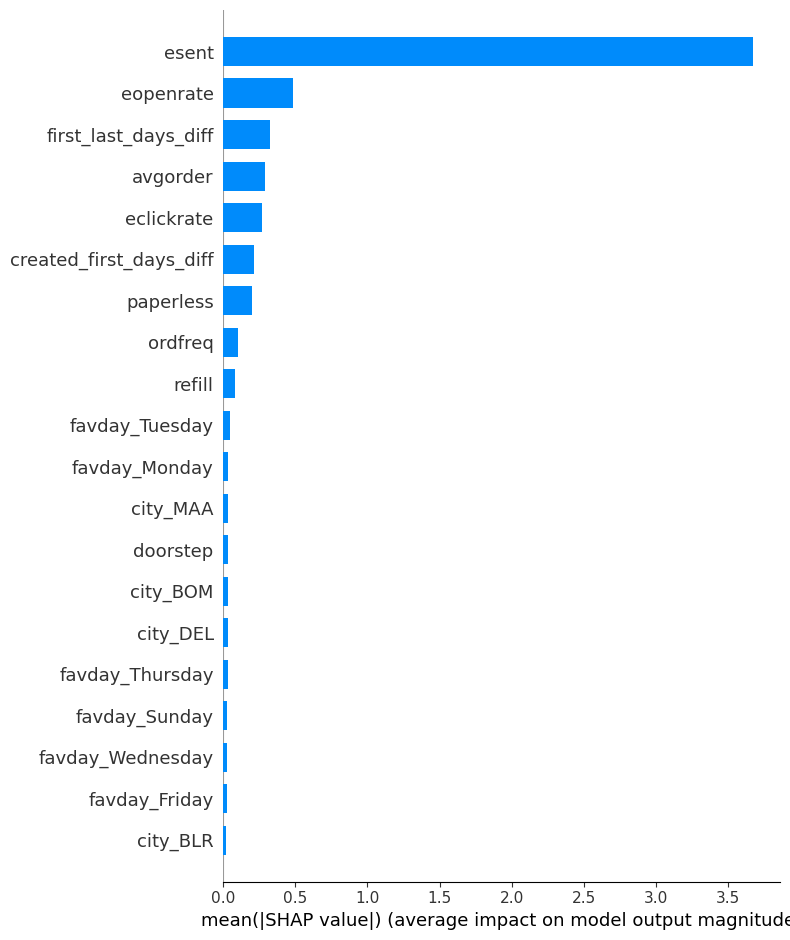

In [38]:
shap_values = trial.tensor("full_shap/f0").value(trial.last_complete_step)
shap_no_base = shap_values[:, :-1]
shap_base_value = shap_values[0, -1]
shap.summary_plot(shap_no_base, plot_type="bar", feature_names=feature_names)

In [39]:
shap_base_value

2.1719913

In [40]:
train_shap = pd.DataFrame(train[:,1:],columns=feature_names)

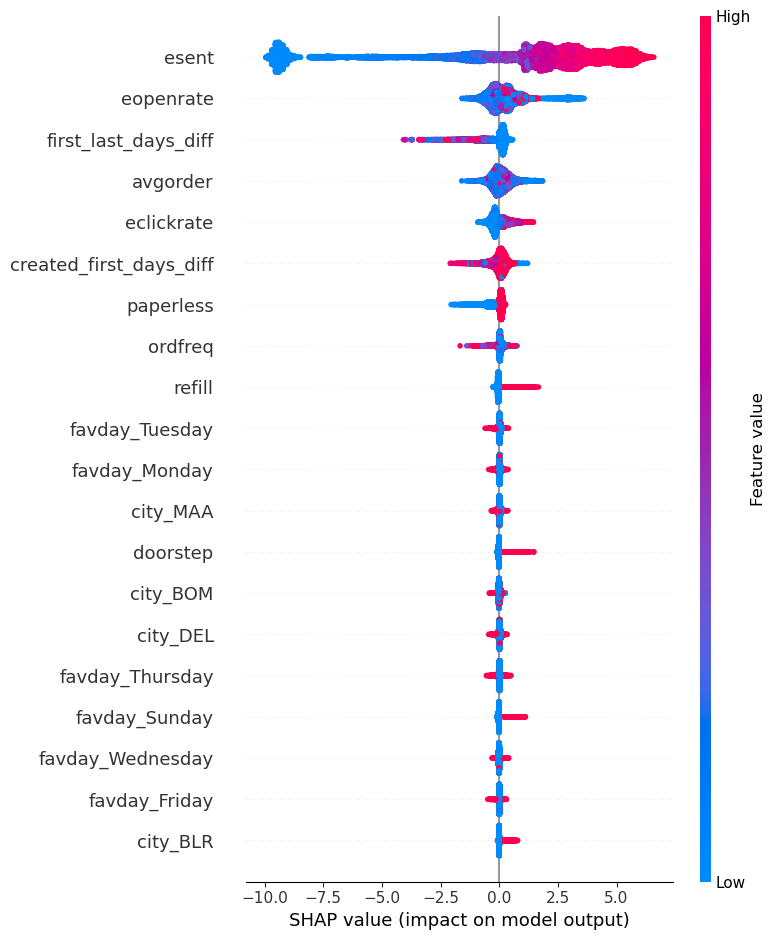

In [41]:
shap.summary_plot(shap_no_base, train_shap)

## Local Explanations

In [42]:
shap.initjs()

In [43]:
shap.force_plot(
    shap_base_value,
    shap_no_base[100, :],
    train_shap.iloc[100, :],
    link="logit",
    matplotlib=False,
)

In [44]:
N_ROWS = shap_no_base.shape[0]
N_SAMPLES = min(100, N_ROWS)
sampled_indices = np.random.randint(N_ROWS, size=N_SAMPLES)

In [45]:
shap.force_plot(
    shap_base_value,
    shap_no_base[sampled_indices, :],
    train_shap.iloc[sampled_indices, :],
    link="logit",
)